In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

In [2]:
!gdown --id 1TKoAQtmKXXNiPtfNz9_ebwL5vIE_-UNf
!unzip -qq lidar-cams-dataset.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TKoAQtmKXXNiPtfNz9_ebwL5vIE_-UNf
To: /content/lidar-cams-dataset.zip
100% 10.0G/10.0G [02:02<00:00, 81.7MB/s]


In [3]:
metadata_file = "lidar-cams-dataset/metadata.csv"
df = pd.read_csv(metadata_file)
print(df.shape, len(df))
df = df.sample(frac=1, random_state=42)
train_df, val_df, test_df = np.split(df, [int(.6*len(df)), int(.8*len(df))])
print('train set: ', len(train_df))
print('val set: ', len(val_df))
print('test set: ', len(test_df))

(19084, 37) 19084
train set:  11450
val set:  3817
test set:  3817


In [ ]:
columns = list(train_df)
n_i = [(n, i) for i, n in enumerate(columns)]
n_i

In [4]:
def expand_split(df_):
  left_df = df_.iloc[:,[0,30]]
  left_df.columns = ["video_mapping", "depth"]
  righ_df = df_.iloc[:,[1,29]]
  righ_df.columns = ["video_mapping", "depth"]
  raw_df = df_.iloc[:,[2,31]]
  raw_df.columns = ["video_mapping", "depth"]
  back_df = df_.iloc[:,[3,28]]
  back_df.columns = ["video_mapping", "depth"]
  # print(back_df.head(), back_df.shape)
  ddff = pd.concat([left_df, righ_df, raw_df, back_df], ignore_index=True, axis=0)
  return ddff
  

In [5]:
train_df = expand_split(train_df)
train_df.shape

(45800, 2)

In [6]:
val_df = expand_split(val_df)
val_df.shape

(15268, 2)

In [ ]:
img=train_df['/video_mapping/left'][0]
print(img)

depth=train_df['/video_mapping/left/depth_map'][0]
print(depth)

video_mapping_left_image_1642031370315.jpg
video_mapping_left_depth_map_1642031370358.png


In [7]:
train_df.head()
# list(train_df)

,video_mapping,depth
0,video_mapping_left_image_1642031370315.jpg,video_mapping_left_depth_map_1642031370358.png
1,video_mapping_left_image_1642542443909.jpg,video_mapping_left_depth_map_1642542443911.png
2,video_mapping_left_image_1642547354988.jpg,video_mapping_left_depth_map_1642547354963.png
3,video_mapping_left_image_1642543374741.jpg,video_mapping_left_depth_map_1642543374779.png
4,video_mapping_left_image_1642547365570.jpg,video_mapping_left_depth_map_1642547365525.png


In [8]:
val_df.head()
# list(val_df)

,video_mapping,depth
0,video_mapping_left_image_1642033136009.jpg,video_mapping_left_depth_map_1642033136033.png
1,video_mapping_left_image_1642545871490.jpg,video_mapping_left_depth_map_1642545871439.png
2,video_mapping_left_image_1642030339214.jpg,video_mapping_left_depth_map_1642030339268.png
3,video_mapping_left_image_1642542927941.jpg,video_mapping_left_depth_map_1642542927965.png
4,video_mapping_left_image_1642032046964.jpg,video_mapping_left_depth_map_1642032047002.png


##Data Generator

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True, test=False):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()
        self.root = '/content/lidar-cams-dataset'
        self.test = test

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_path):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)
        
        depth_map = cv2.imread(depth_path)
        depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=-1)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
        return image_, depth_map

    def data_generation(self, batch):
        if self.test:
            # x = np.empty((self.batch_size, *self.dim, self.n_channels))
            # y = np.empty((self.batch_size, *self.dim, 1))
            views = ['/video_mapping/left', '/video_mapping/right', '/camera/color/image_raw', '/video_mapping/back']
            print('test batch: ', batch)
            batch_images = []
            batch_depths = []
            for i, batch_id in enumerate(batch):
                x = np.empty((4, *self.dim, self.n_channels))
                y = np.empty((4, *self.dim, 1))
                for j,view in enumerate(views):
                    image_path = "{}".format(view)
                    depth_path = "{}/depth_map".format(view)
                    x[j,], y[j,] = self.load(
                            os.path.join(self.root, self.data[image_path][batch_id]),
                            os.path.join(self.root, self.data[depth_path][batch_id])
                        )
                batch_images.append(x)
                batch_depths.append(y)
            # print('batch_images: ', type(batch_images), len(batch_images))
            batch_images = np.stack(batch_images, axis=0)
            batch_depths = np.stack(batch_depths, axis=0)
            return batch_images, batch_depths
            
        else:
            x = np.empty((self.batch_size, *self.dim, self.n_channels))
            y = np.empty((self.batch_size, *self.dim, 1))
            # print('heeeeeee: ', list(self.data))
            for i, batch_id in enumerate(batch):
                # print('-->', self.data["/video_mapping/left"][batch_id])
                # print('-->', self.data["/video_mapping/left/depth_map"][batch_id])
                x[i,], y[i,] = self.load(
                    os.path.join(self.root, self.data["video_mapping"][batch_id]),
                    os.path.join(self.root, self.data["depth"][batch_id])
                )
        return x, y


In [10]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 50
BATCH_SIZE = 32

In [ ]:
input, target = next(iter(DataGenerator(data=train_df, batch_size=6, dim=(HEIGHT, WIDTH))))
print('input: ', type(input), input.shape) 
print('target: ', type(target), target.shape)

input:  <class 'numpy.ndarray'> (6, 256, 256, 3)
target:  <class 'numpy.ndarray'> (6, 256, 256, 1)


##Vizualization

In [11]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        print('input: ', type(input), input.shape) 
        print('pred: ', type(pred), pred.shape)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

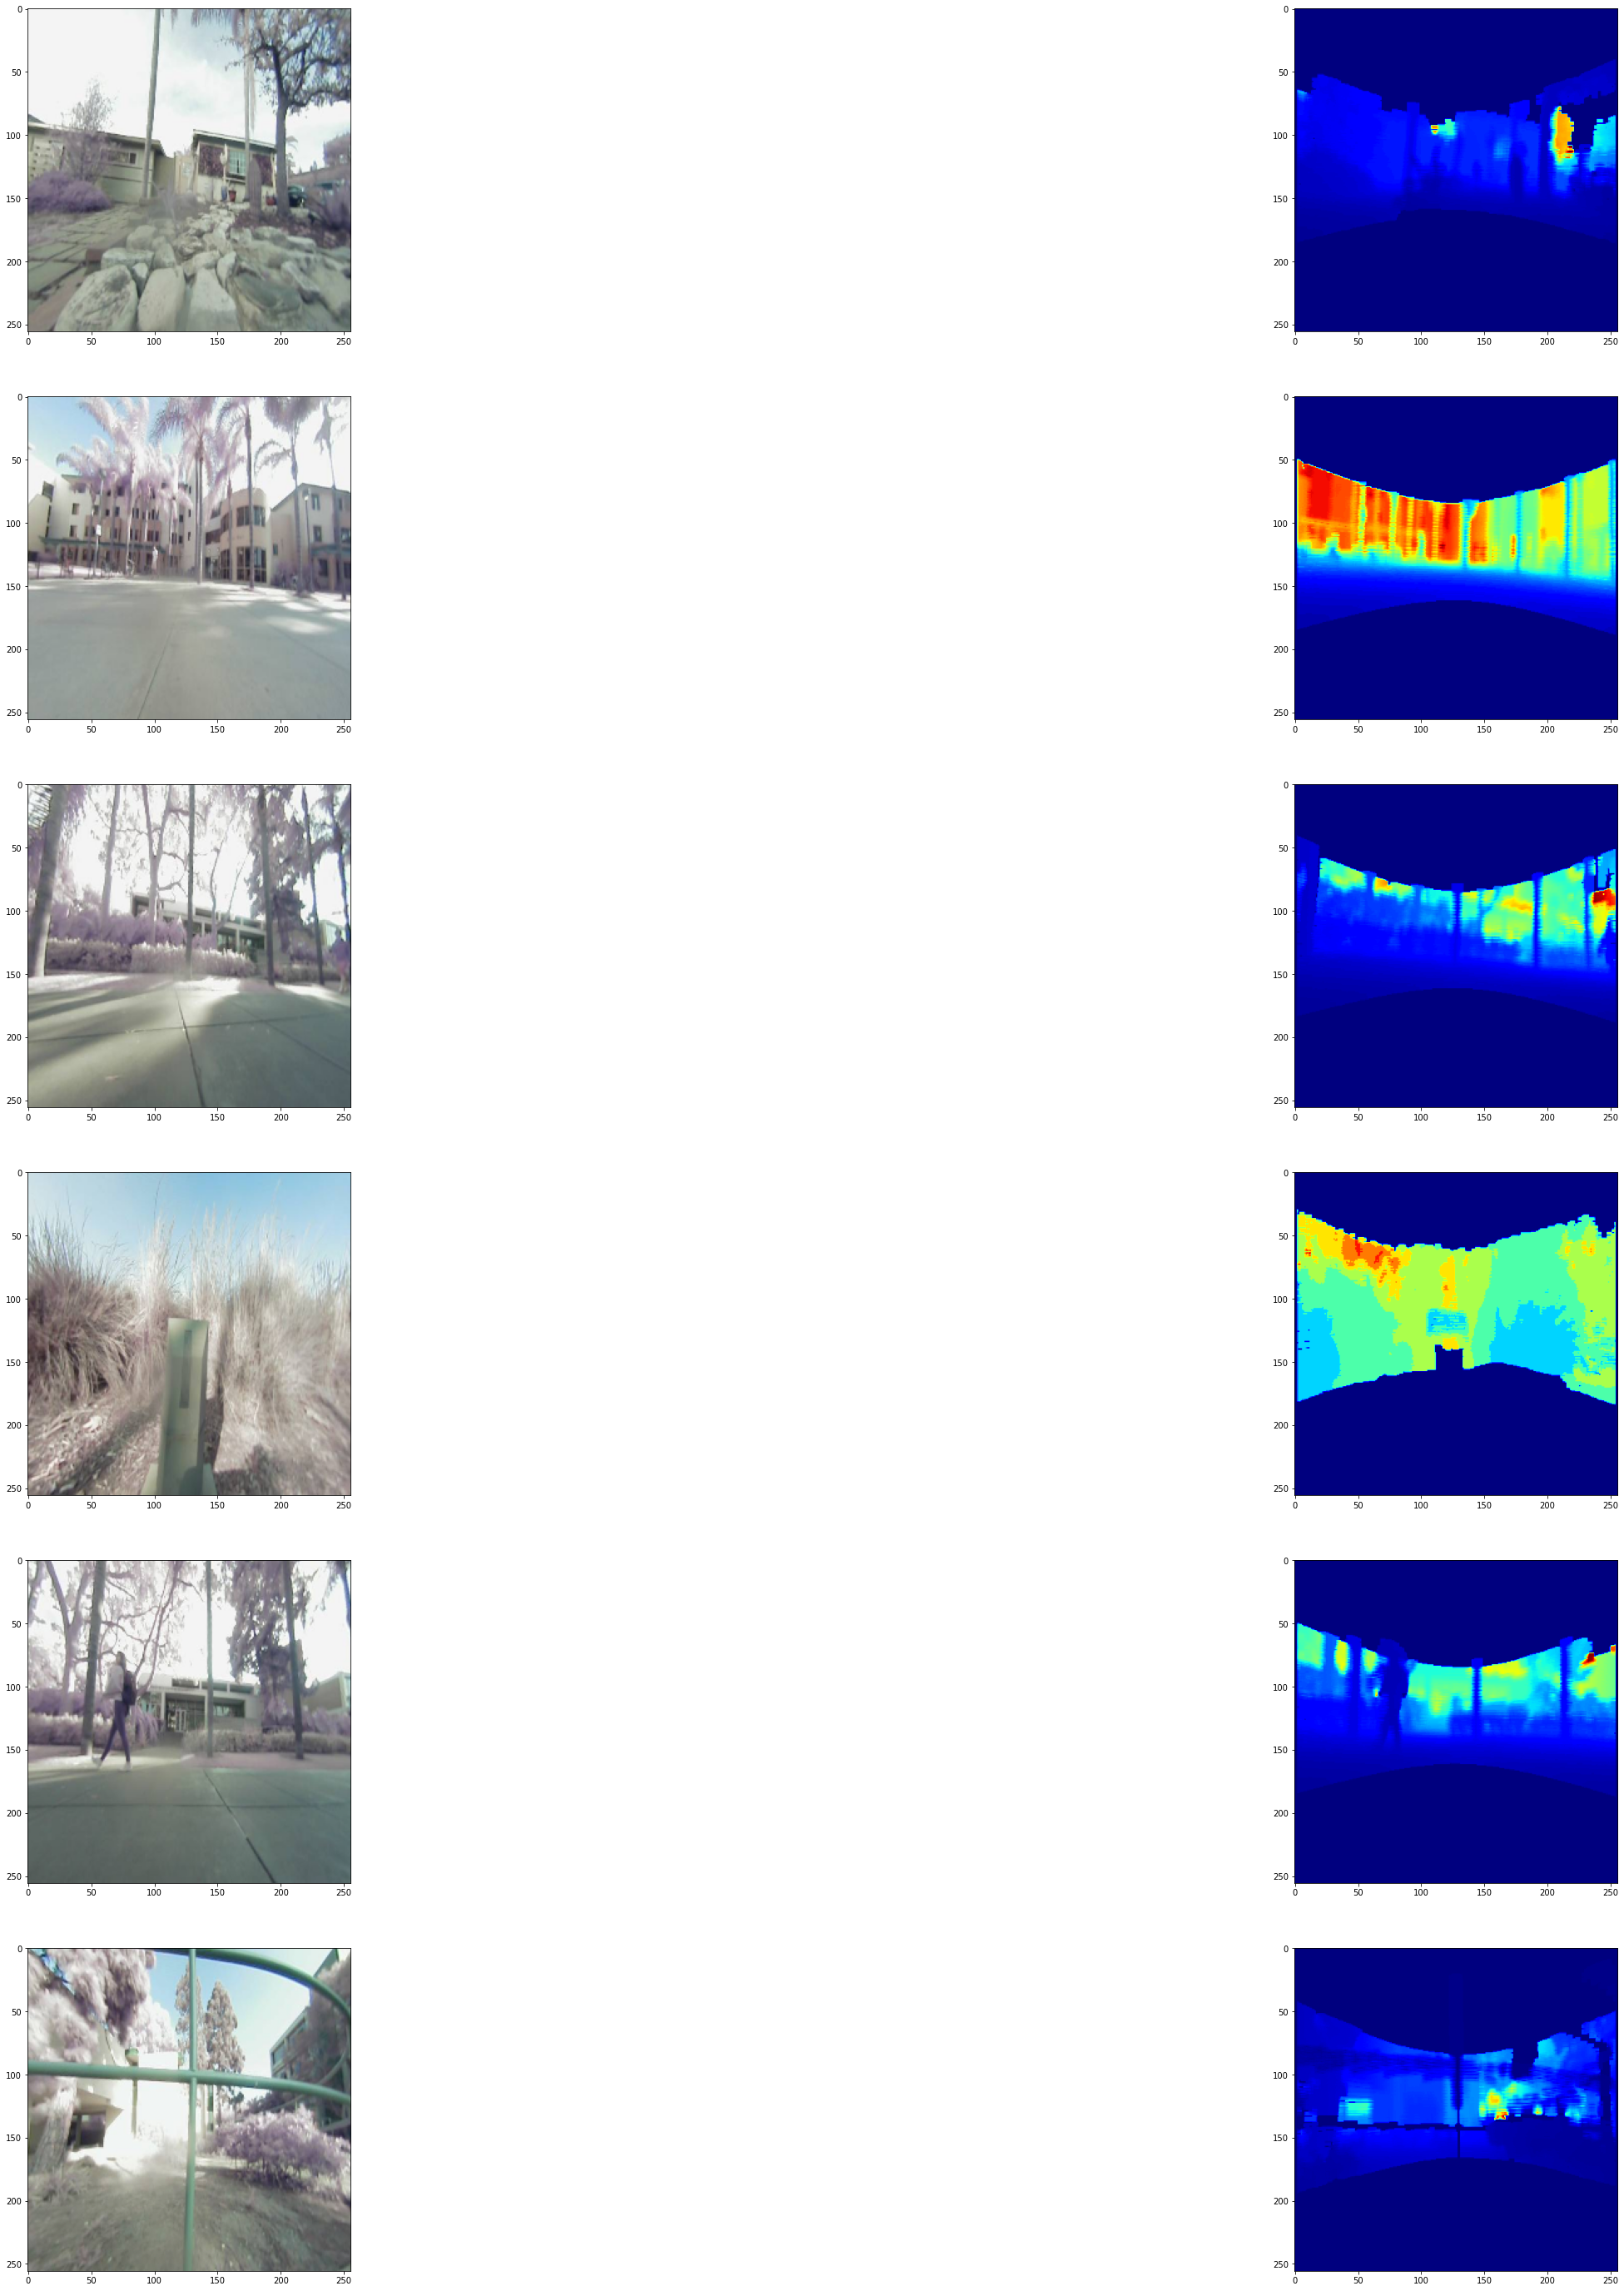

In [ ]:
visualize_samples = next(
    iter(DataGenerator(data=train_df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

## Model

In [12]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

## Loss

In [13]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        # tf.print('train input-->', tf.shape(input), '\n')
        # tf.print('train target-->', tf.shape(target), '\n')
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            # tf.print('train pred-->', tf.shape(pred), '\n')
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data
        print('test_step input: ', tf.shape(input))
        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }
    def predict_step(self, input):
        print('predict_step input: ', type(input), input.shape)
        # print('pppipipi: ', tf.shape(input))
        v, b, w, h, c = input.shape
        # print('v, b, w, h, c :', v, b, w, h, c)
        input = tf.reshape(input, (-1,w,h,c))
        # print('predict_step input reshape: ', input.shape)
        preds = self(input, training=False)
        # print('predict_step preds: ', preds.shape)
        preds = tf.reshape(preds, (-1, b, w, h, 1))
        return preds

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

##Training

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/KIWIBOT_PROJECT/v2',
                                                save_best_only=True,
                                                verbose=1)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

In [ ]:
train_loader = DataGenerator(
    data=train_df.reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=val_df.reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
    callbacks=[checkpoint]
)

Epoch 1/50
1432/1432 [==============================] - ETA: 0s - loss: 0.1913test_step input:  Tensor("Shape:0", shape=(4,), dtype=int32)

Epoch 1: val_loss improved from inf to 0.14801, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 1129s 783ms/step - loss: 0.1913 - val_loss: 0.1480
Epoch 2/50
1432/1432 [==============================] - ETA: 0s - loss: 0.1025
Epoch 2: val_loss improved from 0.14801 to 0.10778, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 290s 202ms/step - loss: 0.1025 - val_loss: 0.1078
Epoch 3/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0830
Epoch 3: val_loss did not improve from 0.10778
1432/1432 [==============================] - 273s 191ms/step - loss: 0.0830 - val_loss: 0.3526
Epoch 4/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0743
Epoch 4: val_loss did not improve from 0.10778
1432/1432 [==============================] - 274s 191ms/step - loss: 0.0743 - val_loss: 0.1449
Epoch 5/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0726
Epoch 5: val_loss did not improve from 0.10778
1432/1432 [==============================] - 271s 189ms/step - loss: 0.0726 - val_loss: 0.1224
Epoch 6/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0672
Epoch 6: val_loss did not improve from 0.10778
1432/1432 [==============================] - 270s 189ms/step - loss: 0.0672 - val_loss: 0.1112
Epoch 7/50
1432/1432 

1432/1432 [==============================] - 275s 192ms/step - loss: 0.0633 - val_loss: 0.1037
Epoch 8/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0597
Epoch 8: val_loss improved from 0.10373 to 0.09378, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 274s 191ms/step - loss: 0.0597 - val_loss: 0.0938
Epoch 9/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0603
Epoch 9: val_loss did not improve from 0.09378
1432/1432 [==============================] - 268s 187ms/step - loss: 0.0603 - val_loss: 0.1345
Epoch 10/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0570
Epoch 10: val_loss improved from 0.09378 to 0.08629, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 275s 192ms/step - loss: 0.0570 - val_loss: 0.0863
Epoch 11/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0548
Epoch 11: val_loss did not improve from 0.08629
1432/1432 [==============================] - 269s 188ms/step - loss: 0.0548 - val_loss: 0.1834
Epoch 12/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0531
Epoch 12: val_loss did not improve from 0.08629
1432/1432 [==============================] - 270s 188ms/step - loss: 0.0531 - val_loss: 0.1183
Epoch 13/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0519
Epoch 13: val_loss did not improve from 0.08629
1432/1432 [==============================] - 271s 189ms/step - loss: 0.0519 - val_loss: 0.1135
Epoch 14/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0501
Epoch 14: val_loss improved from 0.08629 to 0.07583, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 272s 190ms/step - loss: 0.0501 - val_loss: 0.0758
Epoch 15/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0482
Epoch 15: val_loss did not improve from 0.07583
1432/1432 [==============================] - 270s 189ms/step - loss: 0.0482 - val_loss: 0.1480
Epoch 16/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0489
Epoch 16: val_loss improved from 0.07583 to 0.06950, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 273s 191ms/step - loss: 0.0489 - val_loss: 0.0695
Epoch 17/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0464
Epoch 17: val_loss did not improve from 0.06950
1432/1432 [==============================] - 268s 187ms/step - loss: 0.0464 - val_loss: 0.0735
Epoch 18/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0459
Epoch 18: val_loss did not improve from 0.06950
1432/1432 [==============================] - 267s 186ms/step - loss: 0.0459 - val_loss: 0.0730
Epoch 19/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0453
Epoch 19: val_loss did not improve from 0.06950
1432/1432 [==============================] - 265s 185ms/step - loss: 0.0453 - val_loss: 0.0871
Epoch 20/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0438
Epoch 20: val_loss improved from 0.06950 to 0.05820, saving model to /content/drive/MyDrive/KIWIBOT_PROJECT/v2


1432/1432 [==============================] - 273s 191ms/step - loss: 0.0438 - val_loss: 0.0582
Epoch 21/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0453
Epoch 21: val_loss did not improve from 0.05820
1432/1432 [==============================] - 267s 187ms/step - loss: 0.0453 - val_loss: 0.0680
Epoch 22/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0432
Epoch 22: val_loss did not improve from 0.05820
1432/1432 [==============================] - 269s 188ms/step - loss: 0.0432 - val_loss: 0.0651
Epoch 23/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0417
Epoch 23: val_loss did not improve from 0.05820
1432/1432 [==============================] - 271s 189ms/step - loss: 0.0417 - val_loss: 0.0772
Epoch 24/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0414
Epoch 24: val_loss did not improve from 0.05820
1432/1432 [==============================] - 270s 189ms/step - loss: 0.0414 - val_loss: 0.0759
Epoch 25/50
1

1432/1432 [==============================] - 282s 197ms/step - loss: 0.0376 - val_loss: 0.0555
Epoch 36/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0371
Epoch 36: val_loss did not improve from 0.05545
1432/1432 [==============================] - 274s 192ms/step - loss: 0.0371 - val_loss: 0.0656
Epoch 37/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0387
Epoch 37: val_loss did not improve from 0.05545
1432/1432 [==============================] - 274s 192ms/step - loss: 0.0387 - val_loss: 0.0673
Epoch 38/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0367
Epoch 38: val_loss did not improve from 0.05545
1432/1432 [==============================] - 275s 192ms/step - loss: 0.0367 - val_loss: 0.0698
Epoch 39/50
1432/1432 [==============================] - ETA: 0s - loss: 0.0362
Epoch 39: val_loss did not improve from 0.05545
1432/1432 [==============================] - 276s 193ms/step - loss: 0.0362 - val_loss: 0.0680
Epoch 40/50
1

##Test

In [34]:
test_loader = DataGenerator(
    data=test_df.reset_index(drop="true"), batch_size=16, dim=(HEIGHT, WIDTH), test=True
)
input, target = next(iter(test_loader))
print('test input: ', type(input), input.shape) 
print('test target: ', type(target), target.shape)

test batch:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
test input:  <class 'numpy.ndarray'> (16, 4, 256, 256, 3)
test target:  <class 'numpy.ndarray'> (16, 4, 256, 256, 1)


In [17]:
checkpoint_path = '/content/drive/MyDrive/KIWIBOT_PROJECT/v2'
model.load_weights(checkpoint_path)

In [ ]:
# model.evaluate(validation_loader)

In [35]:
# images,labels = next(iter(validation_loader))
images,labels = next(iter(test_loader))
print('images: ', images.shape, len(images))
print('labels: ', labels.shape, len(labels))
preds = model.predict(images)
print('preds out model: ', preds.shape)

test batch:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
images:  (16, 4, 256, 256, 3) 16
labels:  (16, 4, 256, 256, 1) 16
1/1 [==============================] - 14s 14s/step
preds out model:  (16, 4, 256, 256, 1)


In [36]:
cmap = "plasma_r"
def vizualize_preds(images, labels, preds):
  views = ['/video_mapping/left', '/video_mapping/right', '/camera/color/image_raw', '/video_mapping/back']
  for i in range(4):
    plt.figure(figsize=(19,10))

    plt.subplot(1,3,1).set_title(views[i])
    plt.axis("off")
    img1 = images[i]
    plt.imshow(img1)

    pred_cam_1 = preds[i]
    pred_cam_1 = np.squeeze(pred_cam_1, axis=-1)
    plt.subplot(1,3,2).set_title('prediction')
    plt.axis("off")
    plt.imshow(pred_cam_1, cmap=plt.get_cmap(cmap))

    plt.subplot(1,3,3).set_title('ground truth')
    plt.axis("off")
    img = labels[i]
    img = np.squeeze(img, axis=-1)
    plt.imshow(img, cmap=plt.get_cmap(cmap))
    plt.show()

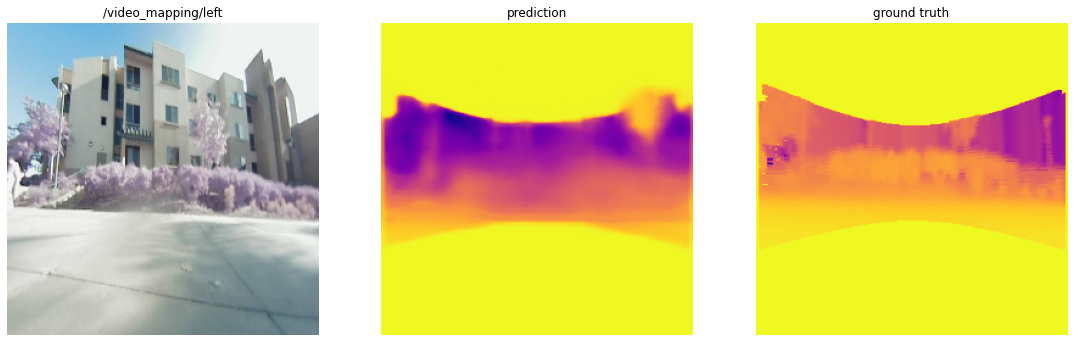

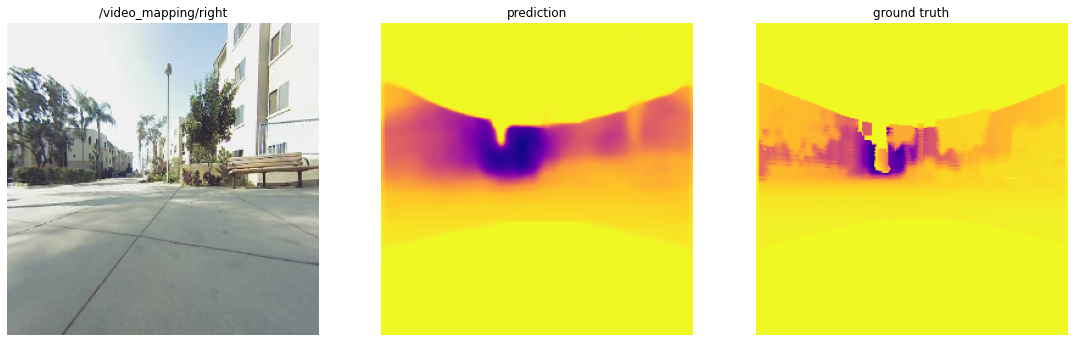

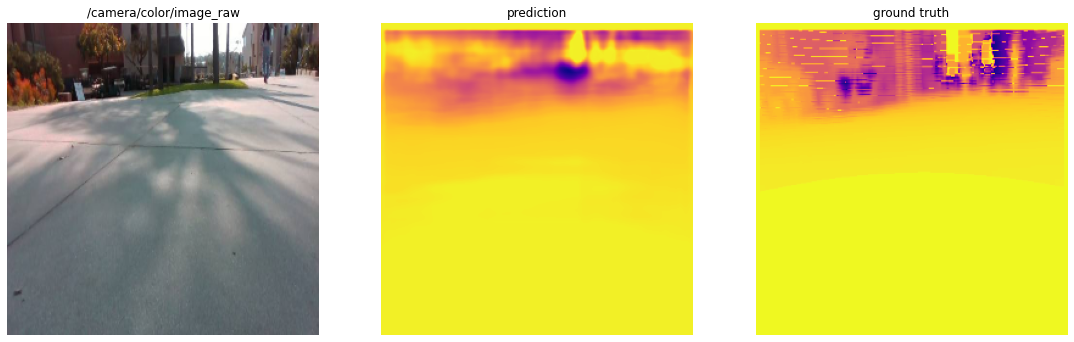

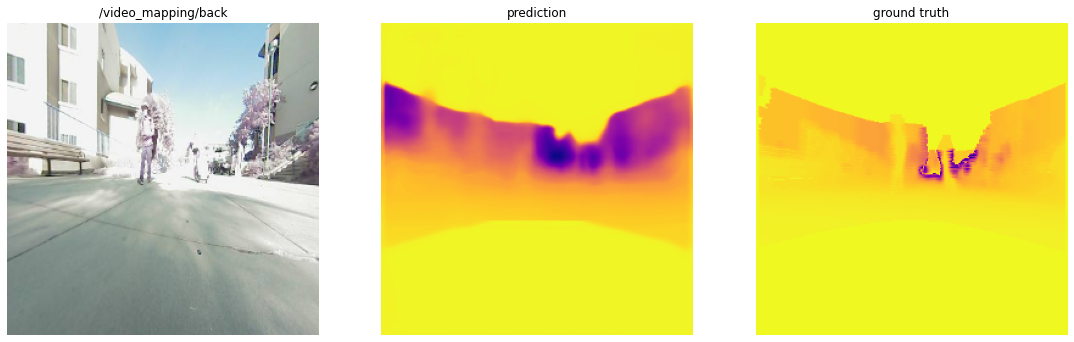

In [38]:
robot_idx = 11
vizualize_preds(images[robot_idx], labels[robot_idx], preds[robot_idx])

In [ ]:
cmap = "plasma_r"


for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()